#### Installing AutoKeras 

In [ ]:
pip install autokeras


     |████████████████████████████████| 174kB 5.5MB/s 
     |████████████████████████████████| 71kB 4.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=d4db00fe322abb701e0b7aea8edc43f54ec35519db2f1f9ea15ee8090050270d
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=1d14d85328158fb2ab5c37d7e3abe80f25f065eb3096f661db3f55ee99a9ad7c
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf
import autokeras as ak

#### Getting the datasets 
Create the datasets generating a random image and structured data as multimodal data

In [ ]:
import numpy as np 
num_instances = 100 

image_data = np.random.rand(num_instances, 32, 32, 3).astype(np.float32) 

structured_data = np.random.rand(num_instances, 20).astype(np.float32) 


And also generate some multi-task targets for classification and regression 

In [ ]:
regression_target = np.random.rand(num_instances, 1).astype(np.float32) 

classification_target = np.random.randint(5, size=num_instances) 

### Creating and training the models

First create the model using AutomoModel its basic configuration

In [ ]:
model = ak.AutoModel( 
    inputs=[ak.ImageInput(), ak.StructuredDataInput()], 
    outputs=[ 
        ak.RegressionHead(metrics=['mae']), 
        ak.ClassificationHead(loss='categorical_crossentropy', metrics=['accuracy']) 
    ], 
    overwrite=True, 
    max_trials=2)


Now run the training to search for the optimal model for the training dataset

In [ ]:
model.fit( 
    [image_data, structured_data], 
    [regression_target, classification_target], 
    epochs=3) 

Trial 2 Complete [00h 00m 33s]
val_loss: 64.71123504638672

Best val_loss So Far: 1.745060920715332
Total elapsed time: 00h 01m 13s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
4/4 [==============================] - 14s 2s/step - loss: 7.9336 - regression_head_1_loss: 5.0938 - classification_head_1_loss: 2.8398 - regression_head_1_mae: 1.7439 - classification_head_1_accuracy: 0.2182
Epoch 2/3
4/4 [==============================] - 7s 2s/step - loss: 21.9110 - regression_head_1_loss: 18.8206 - classification_head_1_loss: 3.0904 - regression_head_1_mae: 3.5696 - classification_head_1_accuracy: 0.3035
Epoch 3/3
4/4 [==============================] - 7s 2s/step - loss: 31.7302 - regression_head_1_loss: 28.6634 - classification_head_1_loss: 3.0668 - regression_head_1_mae: 4.1861 - classification_head_1_accuracy: 0.2071
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


###Visualizing the model

In [ ]:
# First we export the model to a keras model
keras_model = model.export_model()

# Now, we ask for the model Sumary:
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
multi_category_encoding (MultiC (None, 20)           0           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           672         multi_category_encoding[0][0]    
______________________________________________________________________________________________

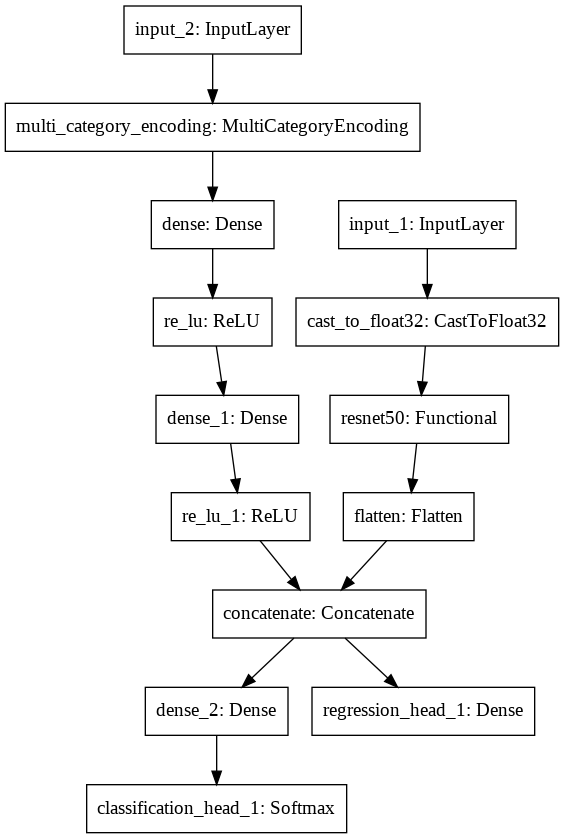

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(keras_model)

### Customizing the search space

We can use AutoModel in a more advanced way customizing the search space by defining the intermediate blocks

In [ ]:
import autokeras as ak

input_node1 = ak.ImageInput()
output_node = ak.Normalization()(input_node1)
output_node = ak.ImageAugmentation()(output_node)
output_node1 = ak.ConvBlock()(output_node)
output_node2 = ak.ResNetBlock(version='v2')(output_node)
output_node1 = ak.Merge()([output_node1, output_node2])

input_node2 = ak.StructuredDataInput()
output_node = ak.CategoricalToNumerical()(input_node2)
output_node2 = ak.DenseBlock()(output_node)

output_node = ak.Merge()([output_node1, output_node2])
output_node1 = ak.ClassificationHead()(output_node)
output_node2 = ak.RegressionHead()(output_node)

model = ak.AutoModel(
    inputs=[input_node1, input_node2], 
    outputs=[output_node1, output_node2],
    overwrite=True,
    max_trials=2)

model.fit(
    [image_data, structured_data],
    [classification_target, regression_target],
    batch_size=32,
    epochs=3)

Trial 2 Complete [00h 00m 48s]
val_loss: 1.6718028783798218

Best val_loss So Far: 1.6718028783798218
Total elapsed time: 00h 01m 28s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
4/4 [==============================] - 28s 6s/step - loss: 3.5850 - classification_head_1_loss: 1.9842 - regression_head_1_loss: 1.6008 - classification_head_1_accuracy: 0.2033 - regression_head_1_mean_squared_error: 1.6008
Epoch 2/3
4/4 [==============================] - 13s 3s/step - loss: 3.6142 - classification_head_1_loss: 1.8070 - regression_head_1_loss: 1.8072 - classification_head_1_accuracy: 0.2538 - regression_head_1_mean_squared_error: 1.8072
Epoch 3/3
4/4 [==============================] - 12s 3s/step - loss: 4.8275 - classification_head_1_loss: 1.7533 - regression_head_1_loss: 3.0742 - classification_head_1_accuracy: 0.2867 - regression_head_1_mean_squared_error: 3.0742
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets
